In [19]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)  # For reproducibility
num_samples = 10000

def generate_random_signal(num_samples):
    magnitudes = np.random.exponential(scale=1.0, size=num_samples)
    polarities = np.random.choice([-1, 1], size=num_samples)
    return magnitudes * polarities

def calculate_sim_snr(input_signal, deq_val, snr_values):
    quant_error = input_signal - deq_val
    signal_power = np.mean(input_signal ** 2)
    error_power = np.mean(quant_error ** 2)
    snr = signal_power / error_power
    snr_db = 10 * np.log10(snr)
    snr_values.append(snr_db)

def calculate_theoretical_snr(n_bits_range):
    return [6.02 * n_bits + 1.76 for n_bits in n_bits_range]

#### 1- Implement a uniform scalar quantizer function with the header

In [ ]:
def UniformQuantizer(in_val, n_bits, xmax, m):
    L = 2 ** n_bits
    delta = (2 * xmax) / L
    shifted_val = in_val - (m * delta / 2)
    q_ind = np.round(shifted_val / delta + L / 2).astype(int)
    q_ind = np.clip(q_ind, 0, L - 1)
    return q_ind

#### 2- Implement a uniform scaler de-quantizer function with the header

In [26]:
def UniformDequantizer(q_ind, n_bits, xmax, m):
    L = 2 ** n_bits
    delta = (2 * xmax) / L
    deq_val = (q_ind - L / 2 + m / 2) * delta
    return deq_val

#### 3- Test the quantizer/dequantizer functions on a deterministic input

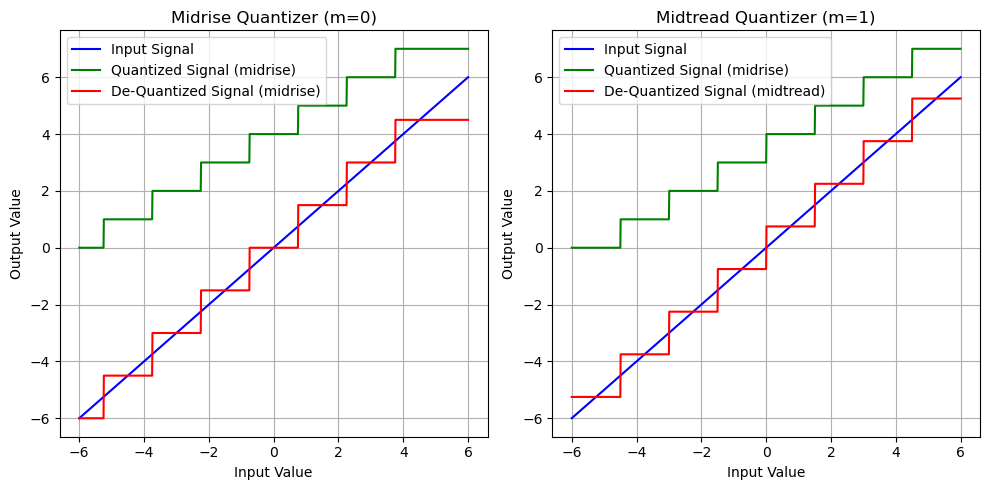

In [27]:
x = np.arange(-6, 6.01, 0.01) # Ramp signal
n_bits = 3
xmax = 6

q_ind_rise = UniformQuantizer(x, n_bits, xmax, 0)
deq_val_rise = UniformDequantizer(q_ind_rise, n_bits, xmax, 0)

q_ind_tread = UniformQuantizer(x, n_bits, xmax, 1)
deq_val_tread = UniformDequantizer(q_ind_tread, n_bits, xmax, 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x, x, 'b-', label='Input Signal')
plt.plot(x, q_ind_rise, 'g-', label='Quantized Signal (midrise)')
plt.plot(x, deq_val_rise, 'r-', label='De-Quantized Signal (midrise)')
plt.grid(True)
plt.xlabel('Input Value')
plt.ylabel('Output Value')
plt.title('Midrise Quantizer (m=0)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, x, 'b-', label='Input Signal')
plt.plot(x, q_ind_tread, 'g-', label='Quantized Signal (midrise)')
plt.plot(x, deq_val_tread, 'r-', label='De-Quantized Signal (midtread)')
plt.grid(True)
plt.xlabel('Input Value')
plt.ylabel('Output Value')
plt.title('Midtread Quantizer (m=1)')
plt.legend()

plt.tight_layout()
plt.show()

#### 4- Now test your input on a random input signal 

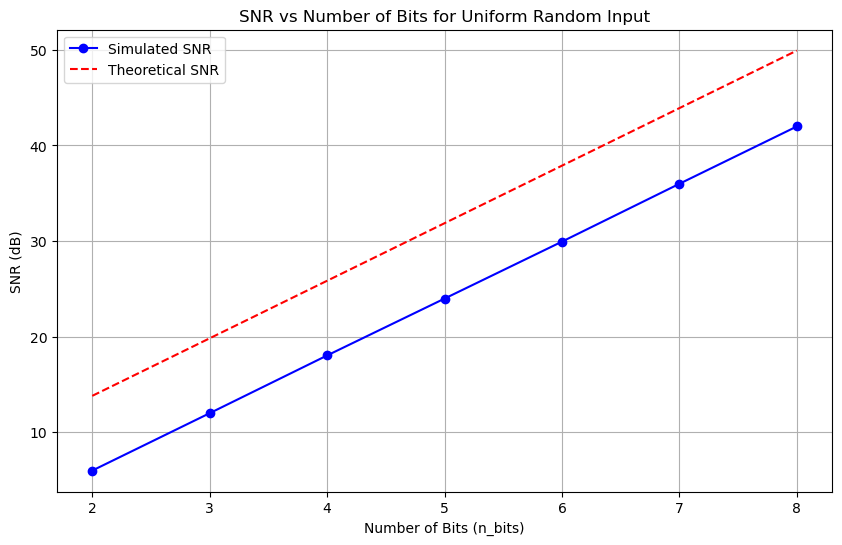

In [17]:
input_signal = np.random.uniform(-5, 5, num_samples)

n_bits_range = range(2, 9)

snr_values = []
for n_bits in n_bits_range:
    q_ind = UniformQuantizer(input_signal, n_bits, 5, 0)
    deq_val = UniformDequantizer(q_ind, n_bits, 5, 0)
    calculate_sim_snr(input_signal, deq_val, snr_values)

theoretical_snr = calculate_theoretical_snr(n_bits_range)

plt.figure(figsize=(10, 6))
plt.plot(n_bits_range, snr_values, 'bo-', label='Simulated SNR')
plt.plot(n_bits_range, theoretical_snr, 'r--', label='Theoretical SNR')
plt.grid(True)
plt.xlabel('Number of Bits (n_bits)')
plt.ylabel('SNR (dB)')
plt.title('SNR vs Number of Bits for Uniform Random Input')
plt.legend()
plt.show()

#### 5- Now test the uniform quantizer on a non-uniform random input

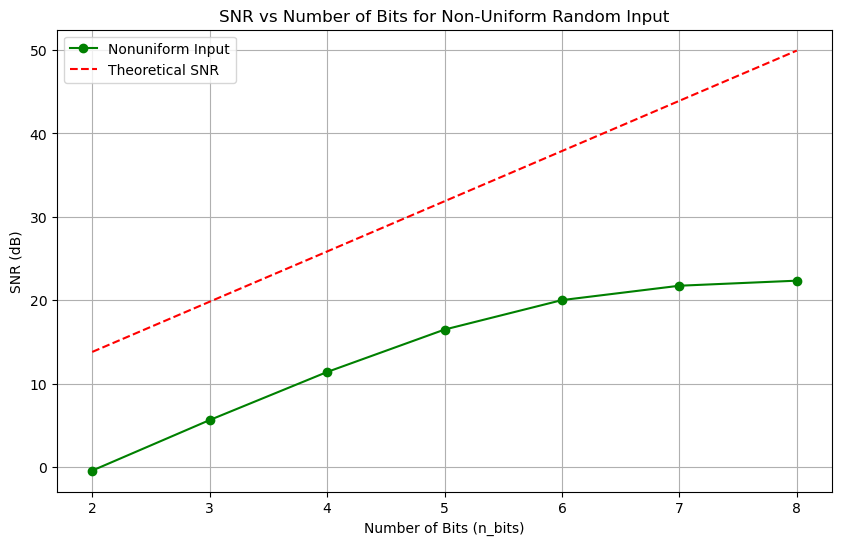

In [18]:
magnitudes = np.random.exponential(scale=1.0, size=num_samples)
polarities = np.random.choice([-1, 1], size=num_samples)
input_signal = magnitudes * polarities

n_bits_range = range(2, 9)

snr_values = []
for n_bits in n_bits_range:
    q_ind = UniformQuantizer(input_signal, n_bits, 5, 0)
    deq_val = UniformDequantizer(q_ind, n_bits, 5, 0)
    calculate_sim_snr(input_signal, deq_val, snr_values)

theoretical_snr = calculate_theoretical_snr(n_bits_range)

plt.figure(figsize=(10, 6))
plt.plot(n_bits_range, snr_values, 'go-', label='Nonuniform Input')
plt.plot(n_bits_range, theoretical_snr, 'r--', label='Theoretical SNR')
plt.grid(True)
plt.xlabel('Number of Bits (n_bits)')
plt.ylabel('SNR (dB)')
plt.title('SNR vs Number of Bits for Non-Uniform Random Input')
plt.legend()
plt.show()


#### 6- Now quantize the the non-uniform signal using a non-uniform μ law quantizer

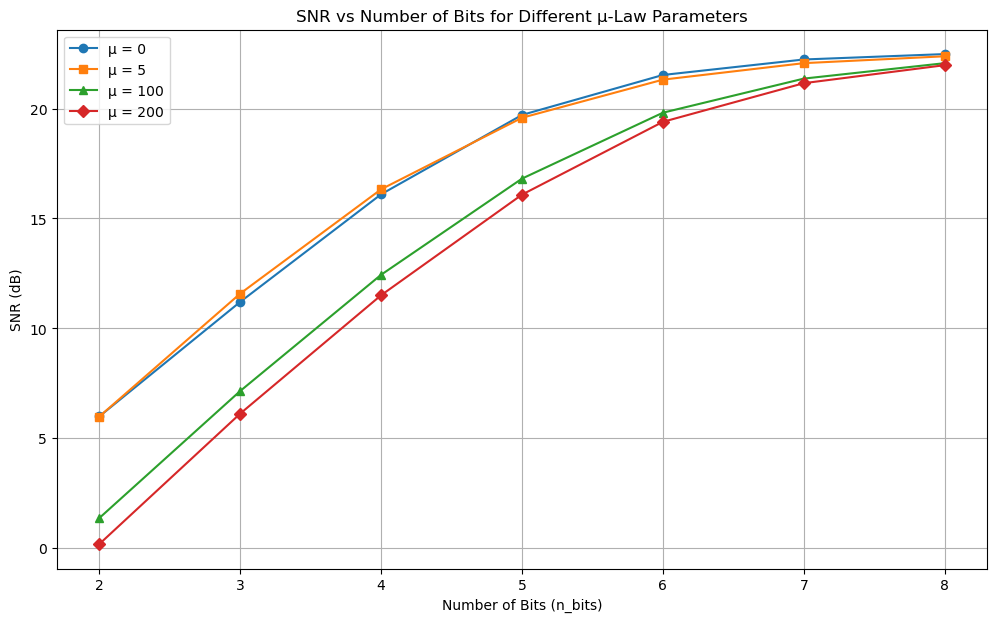

In [28]:
def mu_law_compression(x, mu):
    if mu == 0: return x
    return np.sign(x) * np.log1p(mu * np.abs(x)) / np.log1p(mu)

def mu_law_expansion(x, mu):
    if mu == 0: return x
    return np.sign(x) * (1 / mu) * (np.expm1(np.abs(x) * np.log1p(mu)))

def mu_law_quantization(signal, n_bits, xmax, m, mu):
    compressed_signal = mu_law_compression(signal / xmax, mu)
    q_ind = UniformQuantizer(compressed_signal, n_bits, 1, m)
    deq_val = UniformDequantizer(q_ind, n_bits, 1, m)
    expanded_signal = mu_law_expansion(deq_val, mu) * xmax
    return expanded_signal

mu_values = [0, 5, 100, 200]
n_bits_range = range(2, 9)
all_snr_values = []

for mu in mu_values:
    mu_snr_values = []

    for n_bits in n_bits_range:
        deq_val = mu_law_quantization(input_signal, n_bits, 5, 0, mu)
        calculate_sim_snr(input_signal, deq_val, mu_snr_values)
    
    all_snr_values.append(mu_snr_values)

plt.figure(figsize=(12, 7))
markers = ['o-', 's-', '^-', 'D-']

for i, mu in enumerate(mu_values):
    plt.plot(n_bits_range, all_snr_values[i], markers[i], label=f'μ = {mu}')

plt.grid(True)
plt.xlabel('Number of Bits (n_bits)')
plt.ylabel('SNR (dB)')
plt.title('SNR vs Number of Bits for Different μ-Law Parameters')
plt.legend()
plt.show()
